# Simplified MPC

Checking the implementation from [Reuben Ferrante](https://github.com/arex18/rocket-lander) 

Here the system dynamics matrices are evaluated only once given the current state, input -> So no more need to keep track of **x_bar** and **u_bar**.

This should give less precise results but the computation time should be gratly reduced and the overall code is slimmer, worth checking out!

In [1]:
import numpy as np
import cvxpy as opt
import time
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
plt.style.use("ggplot")

N = 4 #number of state variables
M = 2 #number of control variables
T = 10 #Prediction Horizon
DT = 0.2 #discretization step

L = 0.3 #vehicle wheelbase
MAX_SPEED = 1.5 #m/s
MAX_ACC = 1.0 #m/ss
MAX_D_ACC = 1.0 #m/sss
MAX_STEER = np.radians(30) #rad
MAX_D_STEER = np.radians(30) #rad/s

def get_linear_model_matrices(x_bar,u_bar):
    """
    Computes the LTI approximated state space model x' = Ax + Bu + C
    """
    
    x = x_bar[0]
    y = x_bar[1]
    v = x_bar[2]
    theta = x_bar[3]
    
    a = u_bar[0]
    delta = u_bar[1]
    
    ct = np.cos(theta)
    st = np.sin(theta)
    cd = np.cos(delta)
    td = np.tan(delta)
    
    A = np.zeros((N,N))
    A[0,2] = ct
    A[0,3] = -v*st
    A[1,2] = st
    A[1,3] = v*ct
    A[3,2] = v*td/L
    A_lin = np.eye(N)+DT*A
    
    B = np.zeros((N,M))
    B[2,0]=1
    B[3,1]=v/(L*cd**2)
    B_lin=DT*B
    
    f_xu=np.array([v*ct, v*st, a, v*td/L]).reshape(N,1)
    C_lin = DT*(f_xu - np.dot(A, x_bar.reshape(N,1)) - np.dot(B, u_bar.reshape(M,1)))#.flatten()
    
    #return np.round(A_lin,6), np.round(B_lin,6), np.round(C_lin,6)
    return A_lin, B_lin, C_lin

class MPC():
    
    def __init__(self):
        """
        """
        self.state_len = N
        self.action_len = M
        
    def optimize_linearized_model(self, A, B, C, initial_state, Q, R, target, time_horizon=10, verbose=False):
        """
        Optimisation problem defined for the linearised model,
        :param A: 
        :param B:
        :param C: 
        :param initial_state:
        :param Q:
        :param R:
        :param target:
        :param time_horizon:
        :param verbose:
        :return:
        """
        
        assert len(initial_state) == self.state_len
        # Create variables
        x = opt.Variable((self.state_len, time_horizon + 1), name='states')
        u = opt.Variable((self.action_len, time_horizon), name='actions')

        # Loop through the entire time_horizon and append costs
        cost_function = []

        for t in range(time_horizon):

            _cost = opt.quad_form(target[:, t + 1] - x[:, t + 1], Q) +\
                    opt.quad_form(u[:, t], R) +\
                    opt.quad_form(u[:, t] - u[:, t - 1], R * 0.1)
            
            
            _constraints = [x[:, t + 1] == A @ x[:, t] + B @ u[:, t] + C,
                            u[0, t] >= -MAX_ACC, u[0, t] <= MAX_ACC,
                            u[1, t] >= -MAX_STEER, u[1, t] <= MAX_STEER]
                            #opt.norm(target[:, t + 1] - x[:, t + 1], 1) <= 0.1]
            
            # Actuation rate of change
            if t < (time_horizon - 1):
                _cost += opt.quad_form(u[:,t+1] - u[:,t], R_)
                _constraints += [opt.abs(u[0, t + 1] - u[0, t])/DT <= MAX_D_ACC]
                _constraints += [opt.abs(u[1, t + 1] - u[1, t])/DT <= MAX_D_STEER] #max steer rate of change

            if t == 0:
                #_constraints += [opt.norm(target[:, time_horizon] - x[:, time_horizon], 1) <= 0.01,
                #                x[:, 0] == initial_state]
                _constraints += [x[:, 0] == initial_state]
            
            cost_function.append(opt.Problem(opt.Minimize(_cost), constraints=_constraints))

        # Add final cost
        problem = sum(cost_function)
        
        # Minimize Problem
        problem.solve(verbose=verbose, solver=opt.OSQP)
        return x, u

In [2]:
"""
the ODE is used to update the simulation given the mpc results
I use this insted of using the LTI twice
"""
def kinematics_model(x,t,u):
    """
    Returns the set of ODE of the vehicle model.
    """
    
    L=0.3 #vehicle wheelbase
    dxdt = x[2]*np.cos(x[3])
    dydt = x[2]*np.sin(x[3])
    dvdt = u[0]
    dthetadt = x[2]*np.tan(u[1])/L

    dqdt = [dxdt,
            dydt,
            dvdt,
            dthetadt]

    return dqdt

def predict(x0,u):
    """
    """
    
    x_ = np.zeros((N,T+1))
    
    x_[:,0] = x0
    
    # solve ODE
    for t in range(1,T+1):

        tspan = [0,DT]
        x_next = odeint(kinematics_model,
                         x0,
                         tspan,
                         args=(u[:,t-1],))

        x0 = x_next[1]
        x_[:,t]=x_next[1]
        
    return x_


"""
MODIFIED TO INCLUDE FRAME TRANSFORMATION
"""
def compute_path_from_wp(start_xp, start_yp, step = 0.1):
    """
    Computes a reference path given a set of waypoints
    """
    
    final_xp=[]
    final_yp=[]
    delta = step #[m]

    for idx in range(len(start_xp)-1):
        section_len = np.sum(np.sqrt(np.power(np.diff(start_xp[idx:idx+2]),2)+np.power(np.diff(start_yp[idx:idx+2]),2)))

        interp_range = np.linspace(0,1,np.floor(section_len/delta).astype(int))
        
        fx=interp1d(np.linspace(0,1,2),start_xp[idx:idx+2],kind=1)
        fy=interp1d(np.linspace(0,1,2),start_yp[idx:idx+2],kind=1)
        
        # watch out to duplicate points!
        final_xp=np.append(final_xp,fx(interp_range)[1:])
        final_yp=np.append(final_yp,fy(interp_range)[1:])
    
    dx = np.append(0, np.diff(final_xp))
    dy = np.append(0, np.diff(final_yp))
    theta = np.arctan2(dy, dx)

    return np.vstack((final_xp,final_yp,theta))


def get_nn_idx(state,path):
    """
    Computes the index of the waypoint closest to vehicle
    """

    dx = state[0]-path[0,:]
    dy = state[1]-path[1,:]
    dist = np.hypot(dx,dy)
    nn_idx = np.argmin(dist)

    try:
        v = [path[0,nn_idx+1] - path[0,nn_idx],
             path[1,nn_idx+1] - path[1,nn_idx]]   
        v /= np.linalg.norm(v)

        d = [path[0,nn_idx] - state[0],
             path[1,nn_idx] - state[1]]

        if np.dot(d,v) > 0:
            target_idx = nn_idx
        else:
            target_idx = nn_idx+1

    except IndexError as e:
        target_idx = nn_idx

    return target_idx

def normalize_angle(angle):
    """
    Normalize an angle to [-pi, pi]
    """
    while angle > np.pi:
        angle -= 2.0 * np.pi

    while angle < -np.pi:
        angle += 2.0 * np.pi

    return angle

def get_ref_trajectory(state, path, target_v):
    """
    modified reference in robot frame
    """
    xref = np.zeros((N, T + 1))
    dref = np.zeros((1, T + 1))
    
    #sp = np.ones((1,T +1))*target_v #speed profile
    
    ncourse = path.shape[1]

    ind = get_nn_idx(state, path)
    dx=path[0,ind] - state[0]
    dy=path[1,ind] - state[1]
    
    xref[0, 0] = dx * np.cos(-state[3]) - dy * np.sin(-state[3]) #X
    xref[1, 0] = dy * np.cos(-state[3]) + dx * np.sin(-state[3]) #Y
    xref[2, 0] = target_v                                        #V
    xref[3, 0] = normalize_angle(path[2,ind]- state[3])          #Theta
    dref[0, 0] = 0.0                                             # steer operational point should be 0
    
    dl = 0.05 # Waypoints spacing [m]
    travel = 0.0
    
    for i in range(T + 1):
        travel += abs(target_v) * DT #current V or target V?
        dind = int(round(travel / dl))
        
        if (ind + dind) < ncourse:
            dx=path[0,ind + dind] - state[0]
            dy=path[1,ind + dind] - state[1]
            
            xref[0, i] = dx * np.cos(-state[3]) - dy * np.sin(-state[3])
            xref[1, i] = dy * np.cos(-state[3]) + dx * np.sin(-state[3])
            xref[2, i] = target_v #sp[ind + dind]
            xref[3, i] = normalize_angle(path[2,ind + dind] - state[3])
            dref[0, i] = 0.0
        else:
            dx=path[0,ncourse - 1] - state[0]
            dy=path[1,ncourse - 1] - state[1]
            
            xref[0, i] = dx * np.cos(-state[3]) - dy * np.sin(-state[3])
            xref[1, i] = dy * np.cos(-state[3]) + dx * np.sin(-state[3])
            xref[2, i] = 0.0 #stop? #sp[ncourse - 1]
            xref[3, i] = normalize_angle(path[2,ncourse - 1] - state[3])
            dref[0, i] = 0.0

    return xref, dref

In [3]:
track = compute_path_from_wp([0,3,4,6,10,12,14,6,1,0],
                             [0,0,2,4,3,3,-2,-6,-2,-2],0.05)

# track = compute_path_from_wp([0,10,10,0],
#                              [0,0,1,1],0.05)

sim_duration = 200 #time steps
opt_time=[]
x_sim = np.zeros((N,sim_duration))
u_sim = np.zeros((M,sim_duration-1))

# Starting Condition
x0 = np.zeros(N)
x0[0] = 0               #x
x0[1] = -0.25           #y
x0[2] = 0.0             #v
x0[3] = np.radians(-0)  #yaw
x_sim[:,0] = x0         #simulation_starting conditions

#starting guess
action = np.zeros(M)
action[0] = MAX_ACC/2 #a
action[1] = 0.0      #delta
u_sim[:,0] = action

mpc = MPC()
REF_VEL = 1.0

for sim_time in range(sim_duration-1):
    
    iter_start = time.time()
    
    # dynamics starting state w.r.t. robot are always null except vel 
    start_state = np.array([0, 0, x_sim[2,sim_time], 0])
    action = np.array([u_sim[0,sim_time], u_sim[1,sim_time]])
    
    # State Matrices
    A,B,C = get_linear_model_matrices(start_state, action)

    # Cost Matrices
    Q = np.diag([20,20,10,20]) #state error cost
    Qf = np.diag([30,30,30,30]) #state final error cost
    R = np.diag([10,10])       #input cost
    R_ = np.diag([10,10])      #input rate of change cost

    #Get Reference_traj
    target, _ = get_ref_trajectory(x_sim[:,sim_time] ,track, REF_VEL)
    
    x_mpc, u_mpc = mpc.optimize_linearized_model(A, B, C, start_state, Q, R, target, time_horizon=T, verbose=False)
    
    #retrieved optimized U and assign to u_bar to linearize in next step
    u_bar = np.vstack((np.array(u_mpc.value[0,:]).flatten(),
                      (np.array(u_mpc.value[1,:]).flatten())))
    
    u_sim[:,sim_time] = u_bar[:,0]
    
    # Measure elpased time to get results from cvxpy
    opt_time.append(time.time()-iter_start)
    
    # move simulation to t+1
    tspan = [0,DT]
    x_sim[:,sim_time+1] = odeint(kinematics_model,
                                 x_sim[:,sim_time],
                                 tspan,
                                 args=(u_bar[:,0],))[1]
    
print("CVXPY Optimization Time: Avrg: {:.4f}s Max: {:.4f}s Min: {:.4f}s".format(np.mean(opt_time),
                                                                                np.max(opt_time),
                                                                                np.min(opt_time)))   

CVXPY Optimization Time: Avrg: 0.1026s Max: 0.1282s Min: 0.0958s


### RESUTS

SCS -> Optimization Time: Avrg: 0.2139s Max: 0.3517s Min: 0.1913s

OSQP -> Optimization Time: Avrg: 0.1035s Max: 0.1311s Min: 0.0959s

ECOS -> Avrg: 0.2024s Max: 0.2313s Min: 0.1904s

**Qualitative result** aka "it drives?" seems the same...

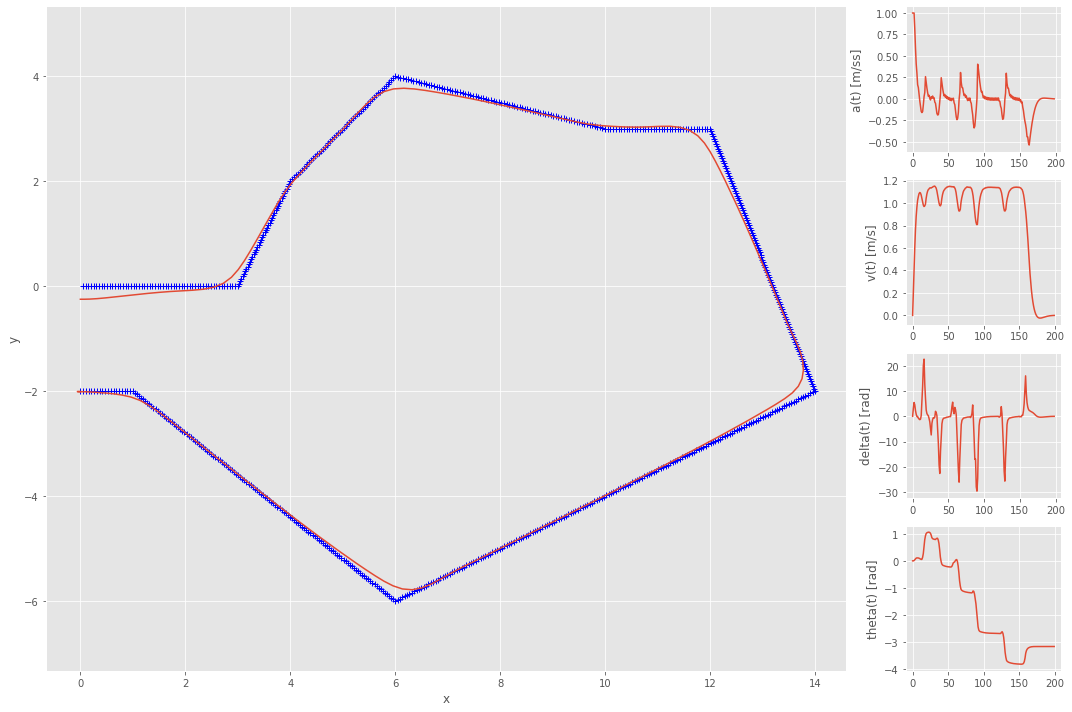

In [4]:
#plot trajectory
grid = plt.GridSpec(4, 5)

plt.figure(figsize=(15,10))

plt.subplot(grid[0:4, 0:4])
plt.plot(track[0,:],track[1,:],"b+")
plt.plot(x_sim[0,:],x_sim[1,:])
plt.axis("equal")
plt.ylabel('y')
plt.xlabel('x')

plt.subplot(grid[0, 4])
plt.plot(u_sim[0,:])
plt.ylabel('a(t) [m/ss]')

plt.subplot(grid[1, 4])
plt.plot(x_sim[2,:])
plt.ylabel('v(t) [m/s]')

plt.subplot(grid[2, 4])
plt.plot(np.degrees(u_sim[1,:]))
plt.ylabel('delta(t) [rad]')

plt.subplot(grid[3, 4])
plt.plot(x_sim[3,:])
plt.ylabel('theta(t) [rad]')

plt.tight_layout()
plt.show()